# N-grams and Fastttext

As you've already learned, fasttext is a useful algorithm for classifying data. It works on either n-grams of words or single character grams. In this assignment, we'll explore both options, that is, a fasttext model created entirely on word n-gram embeddings, and which also uses charcter-grams..

In this assignment, we're going to use the AG-news dataset, consisting of around 120000 different news articles, texts of an average of around 240 symbols each. Each article is labeled as either World(0), Sports(1), Business(2) or Sci/Tech(3). Our end goal will be to use fasttext to predict the label, that is, the subject of  the article based on its content

<span style="color:red">Several places there are 'raise NotImplementedError' lines placed, these will stop the code no matter what, and are just to remind you to do the  cells, the messages in them are not important, and once you have done the code, you can comment them out, no problem </span>

**OPTIONAL: Remind yourself how Fasttext works in a nutshell by watching this handsome guy explain it: Link goes here**


## Installing the fasttext module
See the Assignment discription on DTU Learn 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
import os # Used to get current working directory - standard library, should always be installed
import string # Only used to get alphabet
import re # Regex - Used to change strings
import fasttext # https://fasttext.cc/docs/en/python-module.html
from tqdm import tqdm # For showing progress bars of iterators
# import scipy # Only really used if you don't want to use sklearn's PCA

In [2]:
# Convenient function to seed literally everything with the same seed
# Possibly save it for future projects
# Watch it, might seed differently whether you have cuda or not

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    # try: torch.manual_seed(seed_value) # We don't use torch here, so not necessary
    # except: pass

seed_everything(42069)

In [3]:
# Load data
news_data = np.load('./news_data.npz', allow_pickle=True)
train_texts = news_data['train_texts']
test_texts = news_data['test_texts']
train_labels = news_data['train_labels']
test_labels = news_data['test_labels']
ag_news_labels = news_data['ag_news_label']

print(f"There are a total of {len(train_labels)} data points in the dataset, \n"
      f" {len(test_texts)} different points in the test set, and the different labels are {np.unique(train_labels)}, \n "
      f" these correspond to the categories: {ag_news_labels} ")

There are a total of 120000 data points in the dataset, 
 7600 different points in the test set, and the different labels are [0 1 2 3], 
  these correspond to the categories: ['World' 'Sports' 'Business' 'Sci/Tec'] 


## Wordwise n-grams and characterwise n-grams

Using N-grams is a way of gathering information about specific combinations of words. For example 'not good' is very different from 'good'. It is also a primitive way of captuing the ordering of the words. Say we have a four-word sentence saying 'Maria stole the Milk', this would be the same as 'The milk stole Maria', even though the sentences are quite different... N-grams fix this by making the ordering of the words important.

As you also know: Fasttext takes this one step further: By creating character-wise n-grams. These are made up of n-characters of a single word. This allows fasttext to not only look at combinations of specific words, but at combinations of these specific character n-grams. This is very useful for capturing information about prefixes or suffixes, such as 'dissimilar' vs 'similar' or 'pickle' vs 'pickles' - words that are very much alike, but would be considered as different by other methods.

Specifically, fasttext creates a full embedding vector using character grams as a weighted average of every character gram in the word.

$$v_{total} = \frac{1}{N}\sum^N_{n=0} v_n$$

Every part of a word that is not in the current vocabulary of a the fasttext model, will simply have its $v_n$ set as a zero vector

This also helps in spell-checking, so even if someone maeks a mistaek her and thare, fattext wil still be abel to understnd the text because the character n-grams are almost the same.

**Question: Why do we use n-grams for text classification, and what particular strengths are there in using character-grams?**



$\color{red}{\text{We use n-grams for text classification because it is a way of gathering information about specific combinations of words, and also its construction.}}$
$\color{red}{\text{Due to character-grams, Fasttext can therefore look at alterations of words, that give them a different/wrong meaning,}}$
$\color{red}{\text{and still be able to classify them correctly.}}$
$\color{red}{\text{Character-grams can also help with handling unforseen words by approximating their meaning in the character-based n-grams}}$


In [8]:
import nltk
from nltk.util import ngrams

def get_n_grams(text, n, lower=True, strip=True):
    """Gets a specific n-gram for a given text string"""
    
    # 4 lines to lower text and strip non-alphanumericals
    if lower:
        text = text.lower()
    if strip: # Here we clean the text using regex, later we will use a string translation table
        text = re.sub('[^A-Za-z0-9 ]+', '', text)
    
    text = text.split()
    
    # TODO: Make function to grab word ngrams from text
    n_grams = list(ngrams(text, n))

    return n_grams

def get_word_grams(word, n):
    """Gets the character wise n-grams for a single word"""
    word_grams = []

    # So really this is not something you should do for the actual model
    # String concatenation in python is O(N+M) complexity, which is blazingly slow
    # Probably nltk.ngrams function does it faster
    # Fasttext always adds beginning of word and end of word tokens to the words it is n-gramming:
    word = '<' + word + '>'

    for i, character in enumerate(word):
        if i+n > len(word):
            break
        word_grams.append(word[i:i+n])

    return word_grams

In [9]:
# Now let us just test these functions on some toy text...
text = "He turned himself into a pickle... Funniest shit, I've ever seen!!!"

n_grams = get_n_grams(text, 3, lower=True, strip=True)
word_grams = [get_word_grams(words[0], 3) for words in n_grams]

print("N-grams here: \n ", n_grams)

print("Word-grams here: \n ", word_grams)

N-grams here: 
  [('he', 'turned', 'himself'), ('turned', 'himself', 'into'), ('himself', 'into', 'a'), ('into', 'a', 'pickle'), ('a', 'pickle', 'funniest'), ('pickle', 'funniest', 'shit'), ('funniest', 'shit', 'ive'), ('shit', 'ive', 'ever'), ('ive', 'ever', 'seen')]
Word-grams here: 
  [['<he', 'he>'], ['<tu', 'tur', 'urn', 'rne', 'ned', 'ed>'], ['<hi', 'him', 'ims', 'mse', 'sel', 'elf', 'lf>'], ['<in', 'int', 'nto', 'to>'], ['<a>'], ['<pi', 'pic', 'ick', 'ckl', 'kle', 'le>'], ['<fu', 'fun', 'unn', 'nni', 'nie', 'ies', 'est', 'st>'], ['<sh', 'shi', 'hit', 'it>'], ['<iv', 'ive', 've>']]


**Question: We've now made a function for grabbing character-wise and word-wise n-grams for words, what downsides are there for training an ML model on n-grams (character-wise or word-wise)**

Training a NN model on this probably needs a bunch of parameters and will very quickly become computationally difficult to run.

This will especially be the case for character-based n-grams. ML models often also need a bunch of data, which could also be an issue. 

Character-based n-grams are great for smaller corpus' but computationally expensive.

## Training the fasttext model

To simplify things a bit, we're going to be using the 'fasttext' module to create the model. The package allows for the creation of a fasttext model quite easily, by simply giving a .txt training document of both labels and training data.

The good thing about this model (aside from how fast it trains), is that you can tweak just about every parameter about the model if you so choose. For this project we're going to focus on tweaking minn and maxnn, which control the minimum and maximum length of the character n-grams, although feel free to test how tweaking the other hyperparamters, impacts the performance of the model. Do note, that the default n-gram length, denoted wordNgrams in create_supervised, has a default value of 1, so technically, the default, wordwise fasttext model, does not use ngrams.

A complete list of hyperparameters can be found in the file hyperparams.txt along with most methods callable on the fasttext model, as well as parameters for the object itself.

Important note: If the model is asked for a word-vector not in its current vocabulary, it will give a zero-vector of the same dimension as the other vectors in its vocabulary; that way even extremely esoteric spelling errors do not 'break' the model due to vocabulary lookup errors, the words themselves will just not add anything to the prediction.

In [10]:
# Let's just ensure there are no unfair class balances in either training or testing...
n_classes = len(ag_news_labels)

print("Training class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(train_labels==i))

print("Test class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(test_labels==i))

Training class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tec 0.25
Test class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tec 0.25


In [12]:
# Creating fasttext data set from current training data
# I know it sounds weird, but for some reason, the module NEEDS data as a path to a txt file...

txt = ""
for i in tqdm(range(len(train_texts))):
    trains = train_texts[i]
    tests = train_labels[i]
    # Perhaps comment out two lines below, see if it impacts performance
    trains = trains.lower()
    trains = re.sub('[^A-Za-z0-9 ]+', '', trains) # Remove all non-alphanumeraicals from the text

    txt = txt + f'__label__{ag_news_labels[tests]} {trains}\n'

path_to_doc = os.getcwd() + '/training_data.txt'
f = open(path_to_doc, mode='w')
f.write(txt)
f.close()

# Defining fasttext hyperparameters
char_gram_length_min = 3 # If set to zero, we only train word-grams
char_gram_length_max = 6 # If set to zero, we only train word-grams
num_word_grams = 1 # Default value
verbose = True # Set to false if you don't want to see training statistics

fasttext_word_model = fasttext.train_supervised(path_to_doc, maxn=0, minn=0, verbose=verbose,
                                                wordNgrams=num_word_grams)
fasttext_char_model = fasttext.train_supervised(path_to_doc, maxn=char_gram_length_max, minn=char_gram_length_min,
                                                verbose=verbose, wordNgrams=num_word_grams)

100%|██████████| 120000/120000 [03:02<00:00, 656.47it/s]
Read 4M words
Number of words:  91297
Number of labels: 4
Progress: 100.0% words/sec/thread: 1508638 lr:  0.000000 avg.loss:  0.268540 ETA:   0h 0m 0s
Read 4M words
Number of words:  91297
Number of labels: 4
Progress: 100.0% words/sec/thread:  199895 lr:  0.000000 avg.loss:  0.393563 ETA:   0h 0m 0s


In [13]:
# Example of how the subwords of the character model and the word model differ
# get_subwords gets all character-gram 'parts' of the word specified...
# ...as well as indices corresponding to the row of the given vector in the embedding matrix
print(fasttext_word_model.get_subwords('cat'))
print(fasttext_char_model.get_subwords('cat'))

(['cat'], array([4531]))
(['cat', '<ca', '<cat', '<cat>', 'cat', 'cat>', 'at>'], array([   4531, 1008044, 2080270, 1519434,  380328, 1219292,  442403]))


In [44]:
def test_prediction(test_text, test_label, model):
    """
    Method for testing fasttext model
    Model should be either the character model or the word model
    """
    prediction = model.predict(test_text)
    if prediction[0][0][9:] == test_label:
        return True

    return False

# Reason why we index the way we do: .predict outputs a tuple of certainty and the label, the label being __label__Business for example for business
print(fasttext_word_model.predict('A cat in a hat')[0][0][9:])
predicts = fasttext_word_model.predict(list(test_texts))

Sci/Tec


In [45]:
print(len(test_labels))

7600


In [72]:
# Make the testing loop here to obtain accuracy of when predicting labels,
# it is reccomended to use the test_prediction function defined above


# TODO: GET ACCURACY OF EITHER fasttext_word_model or fasttext_char_model

def test_accuracy(model, texts):
    correct = 0
    for i in range(len(texts)):
        text = texts[i]
        from_number_to_string = ["World", "Sports", "Business", "Sci/Tec"]
        label = from_number_to_string[test_labels[i]]
        if test_prediction(text, label, model):
            correct += 1
    print(round(correct/len(test_texts)*100, 2), "% correct")
    return correct/len(test_texts)*100


test_accuracy(fasttext_word_model, test_texts)
test_accuracy(fasttext_char_model, test_texts)

90.91 % correct
90.16 % correct


90.15789473684211

**Fill in the blanks (either by a loop or a function) to calculate the accuracy of the fasttext word model when predicting one of the four classes, the meaning of this is to do it yourself, possibly using the test_prediction function already defined, not by using the innate test function, defined by the fasttext object**

## Examining the emebdding vectors

We musn't forget, that at its core, fasttext is a method functioning on word embedding vectors, which it obtains by a skipgram model using some clever tricks. As such, we can expect the embeddings that are created by the fasttext model to hold some information about the words they 'code for'. We now wish to perform PCA on the entire word-embedding matrix to see if the semantic difference in words is visible with only a few principal components

If you want to read more about word2vec and skipgram models, I reccomend: [here first](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/): and: [here afterwards](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)



**Explain shortly what you expect to find if we perform PCA on the matrix of text embeddings, that is the matrix which holds the mean vector representation of every text in our dataset**

We expect to find clusters of text embeddings in the plots based on the label they refer to.


In [49]:
feats_train = []
feats_test = []

def clean(text):
    """
    Cleaning text of non-alphanumerics using the aforementioned string translation table
    """
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator).lower()

# Get the average embedding vector for each text in the training set
for text in tqdm(train_texts):
   words = clean(text).split()
   feats_train.append(np.mean([fasttext_word_model.get_word_vector(word) for word in words], axis=0))

# Same but for each text in test set
for text in tqdm(test_texts):
    words = clean(text).split()
    feats_test.append(np.mean([fasttext_word_model.get_word_vector(word) for word in words], axis=0))

100%|██████████| 7600/7600 [00:02<00:00, 3613.94it/s]


### Compute PCA and plot the projections of both training and test versions onto PC1 vs. PC2, PC2 vs. PC3, PC3 vs. PC4.

Next, we want to plot how well the data can be seperated by just the first two principal components of the embedding matrix for a given fasttext model

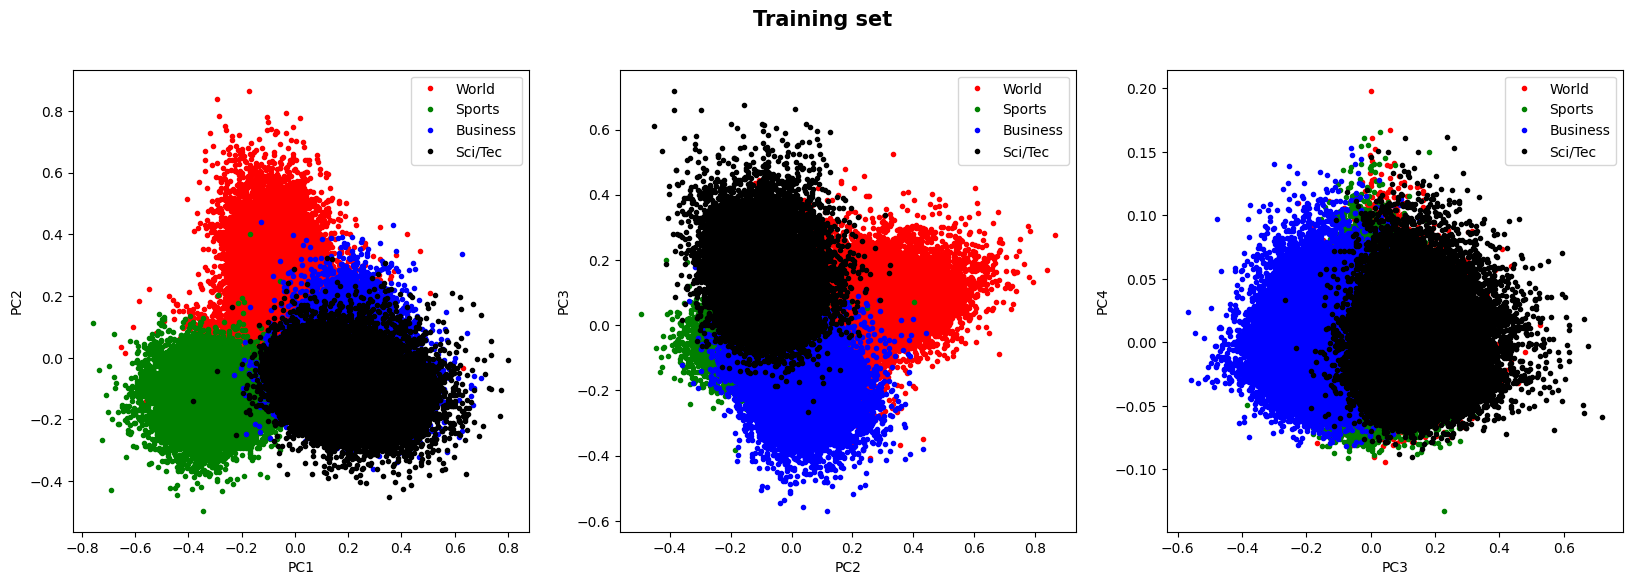

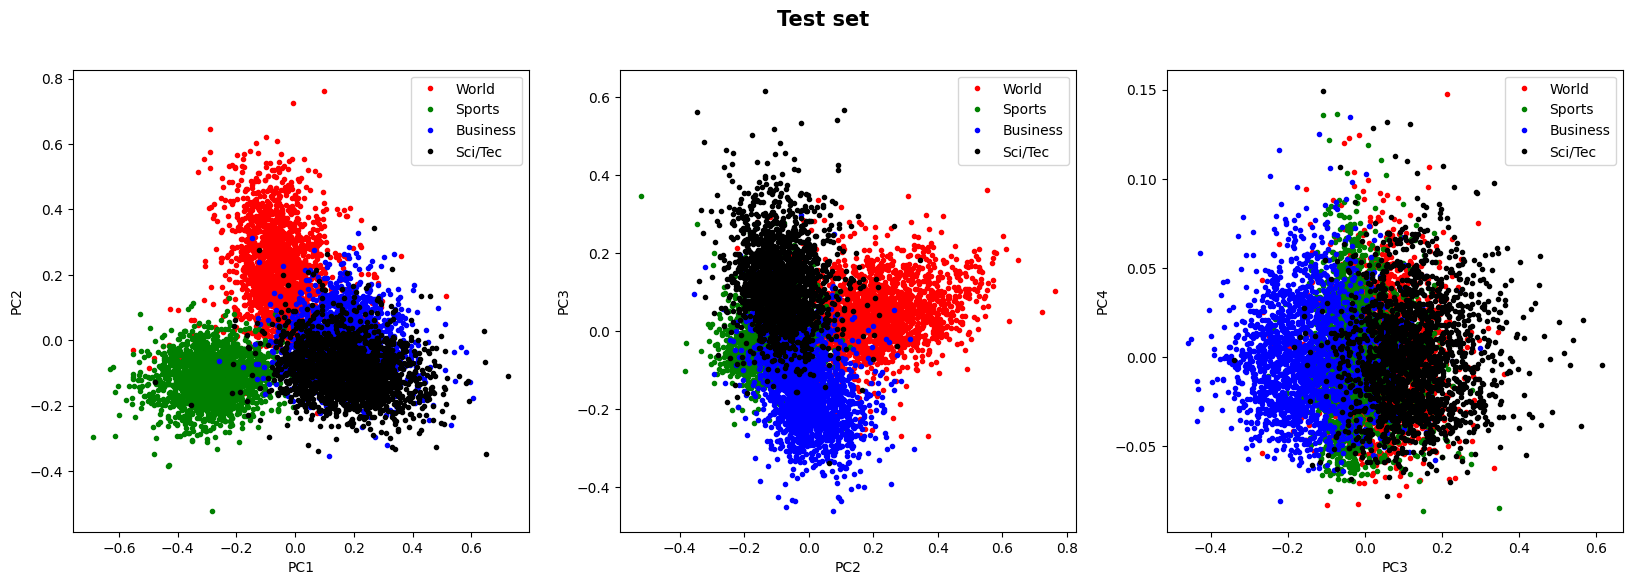

In [50]:
feats_train = np.array(feats_train)
feats_test = np.array(feats_test)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

pca_word_vec = PCA(n_components=100)
pca_char_vec = PCA(n_components=100)

# fit_transform avoids having to manually transform the vectors with the matrix afterwards
Vtrain = pca_word_vec.fit_transform(feats_train)
Vtest = pca_word_vec.fit_transform(feats_test)

colors = 'rgbk'
for label, transformed_vector, title in zip([train_labels, test_labels], [Vtrain, Vtest], ['Training set', 'Test set']):

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)
    for i in range(4):
        plt.plot(transformed_vector[label==i, 0], transformed_vector[label==i, 1], '.', color=colors[i], label=ag_news_labels[i])
    plt.legend()
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.subplot(1, 3, 2)
    for i in range(4):
        plt.plot(transformed_vector[label==i, 1], transformed_vector[label==i, 2], '.', color=colors[i], label=ag_news_labels[i])
    plt.legend()
    plt.xlabel('PC2')
    plt.ylabel('PC3')

    plt.subplot(1, 3, 3)
    for i in range(4):
        plt.plot(transformed_vector[label==i, 2], transformed_vector[label==i, 3], '.', color=colors[i], label=ag_news_labels[i])
    plt.legend()
    plt.xlabel('PC3')
    plt.ylabel('PC4')
    plt.suptitle(title, fontweight='bold', fontsize=15)

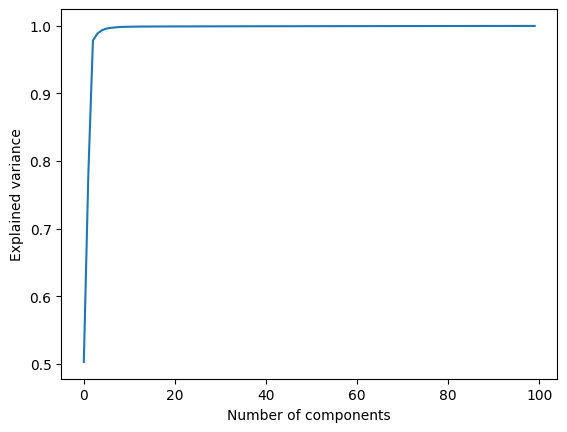

In [51]:
#plt.plot(pca_word_vec.explained_variance_ratio_,"--*");
plt.plot(list(range(100)),np.cumsum(pca_word_vec.explained_variance_ratio_));
plt.xlabel("Number of components");
plt.ylabel("Explained variance")
plt.show()

**Repeat the previous steps using the character model. i.e. compute the mean embedding for each document using fasttext_char_model and plot the projection of both training and test sets unto PC1 vs. PC2, PC2 vs. PC3, PC3 vs. PC4.**

**Plot the explained variance as a function of principal components for the fasttext_char_model**

**Comment on how the two FastText models do, seperating the different classes**

100%|██████████| 7600/7600 [00:01<00:00, 4068.58it/s]


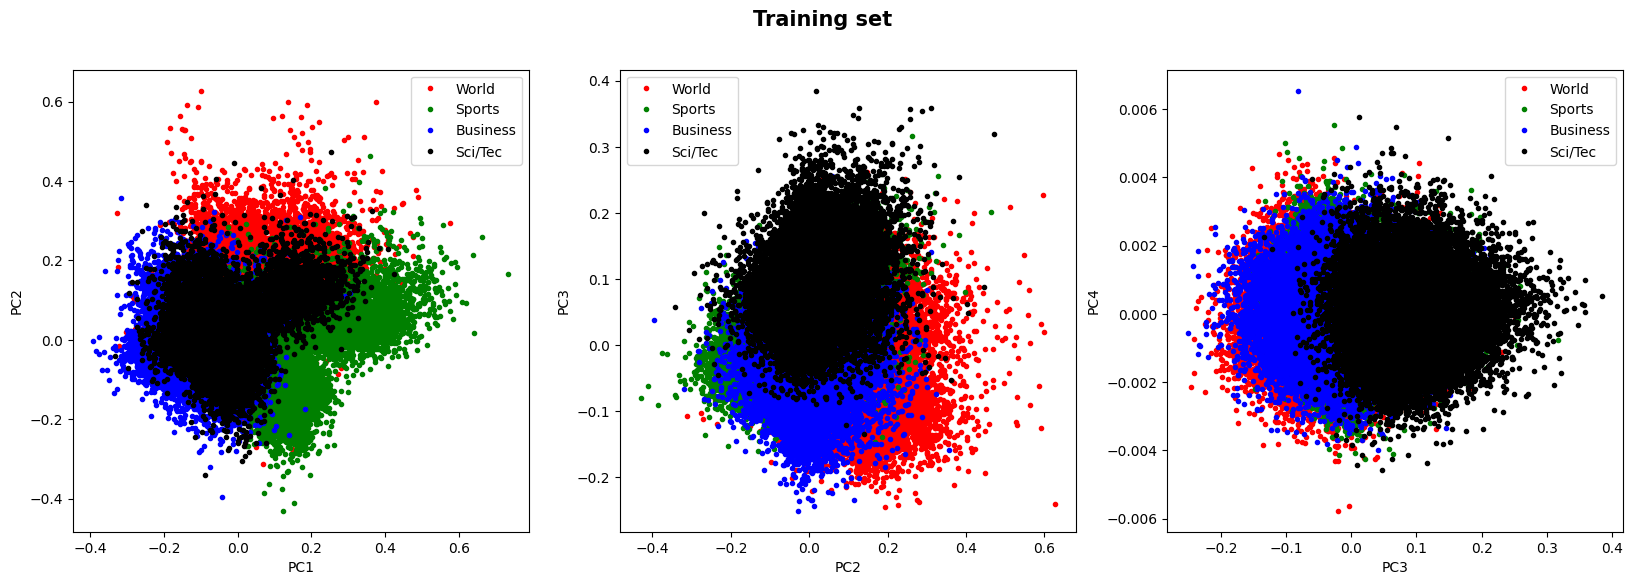

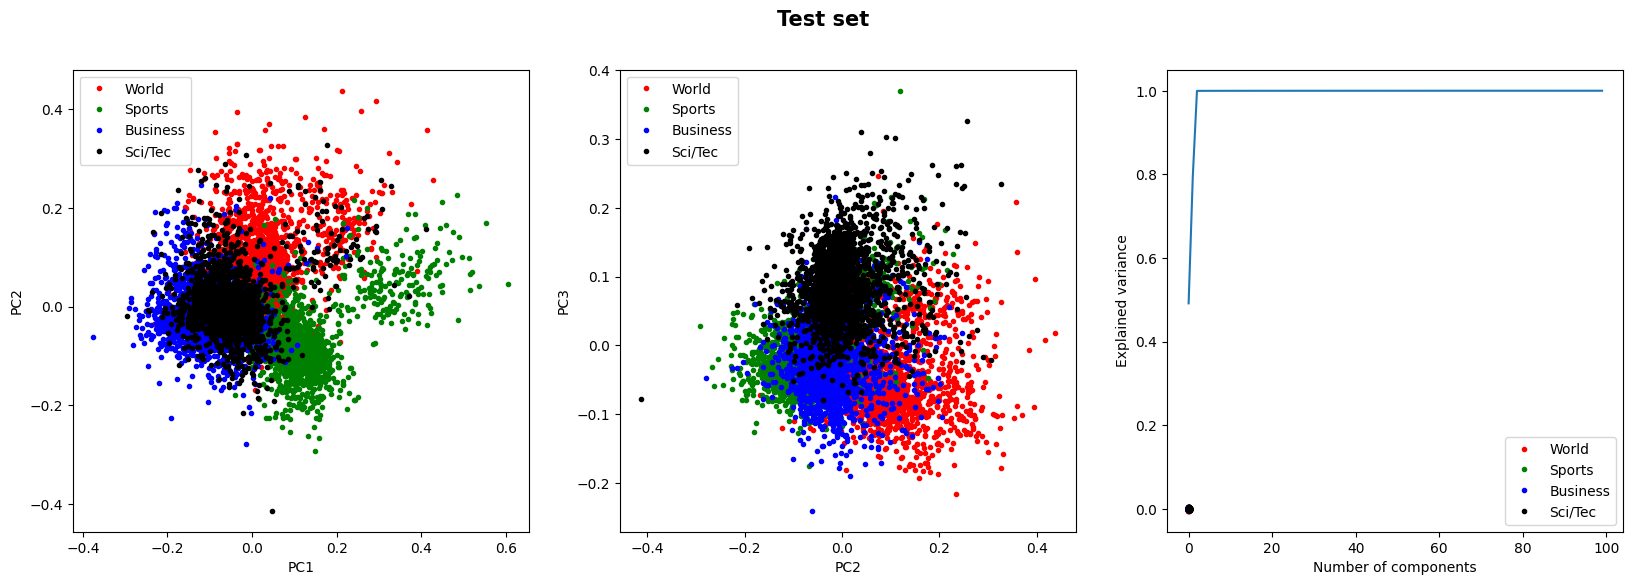

In [52]:
feats_train = []
feats_test = []

def clean(text):
    """
    Cleaning text of non-alphanumerics using the aforementioned string translation table
    """
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator).lower()

# Get the average embedding vector for each text in the training set
for text in tqdm(train_texts):
   words = clean(text).split()
   feats_train.append(np.mean([fasttext_char_model.get_word_vector(word) for word in words], axis=0))

# Same but for each text in test set
for text in tqdm(test_texts):
    words = clean(text).split()
    feats_test.append(np.mean([fasttext_char_model.get_word_vector(word) for word in words], axis=0))

feats_train = np.array(feats_train)
feats_test = np.array(feats_test)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

pca_word_vec = PCA(n_components=100)
pca_char_vec = PCA(n_components=100)

# fit_transform avoids having to manually transform the vectors with the matrix afterwards
Vtrain = pca_word_vec.fit_transform(feats_train)
Vtest = pca_word_vec.fit_transform(feats_test)

colors = 'rgbk'
for label, transformed_vector, title in zip([train_labels, test_labels], [Vtrain, Vtest], ['Training set', 'Test set']):

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)
    for i in range(4):
        plt.plot(transformed_vector[label==i, 0], transformed_vector[label==i, 1], '.', color=colors[i], label=ag_news_labels[i])
    plt.legend()
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.subplot(1, 3, 2)
    for i in range(4):
        plt.plot(transformed_vector[label==i, 1], transformed_vector[label==i, 2], '.', color=colors[i], label=ag_news_labels[i])
    plt.legend()
    plt.xlabel('PC2')
    plt.ylabel('PC3')

    plt.subplot(1, 3, 3)
    for i in range(4):
        plt.plot(transformed_vector[label==i, 2], transformed_vector[label==i, 3], '.', color=colors[i], label=ag_news_labels[i])
    plt.legend()
    plt.xlabel('PC3')
    plt.ylabel('PC4')
    plt.suptitle(title, fontweight='bold', fontsize=15)

#plt.plot(pca_word_vec.explained_variance_ratio_,"--*");
plt.plot(list(range(100)),np.cumsum(pca_word_vec.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()

The word based model seem to be able to cluster the 4 different classifications much better than the character model is.

Of course plotting vectors can only really be done in two or three dimensions max, for more dimensions, we can use the cosine similarity previously defined to measure how similar two word vectors are

**Create your own functions for getting the cosine similarity between two vectors and another function for transforming a given vector based on the first n principle components of a given model's embedding matrix**


In [56]:
def cos_sim(vec1, vec2):
    """
    Should give two vectors, obtain cosine simliarity for them
    """
    cossim = np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    # TODO: Compute cosine similarity of two vectors
    return cossim

def get_vector_transform(word, model, n=2):
    """
    Should given a specific word string, obtain fasttext's vector representation of that word and project it on the n first principal components
    model should be either your word_model or the character model
    """
    if model == fasttext_char_model:
        pca_matrix = pca_char_vec.components_
    elif model == fasttext_word_model:
        pca_matrix = pca_word_vec.components_
    else:
        print("Wrong model specified")

    word_vec = model.get_word_vector(word)
    
    # TODO project word_vec to first n principal components of pca_matrix
    transformed_vector = np.dot(pca_matrix, word_vec)

    return transformed_vector

Text(0, 0.5, 'Latent Semantic dim 2')

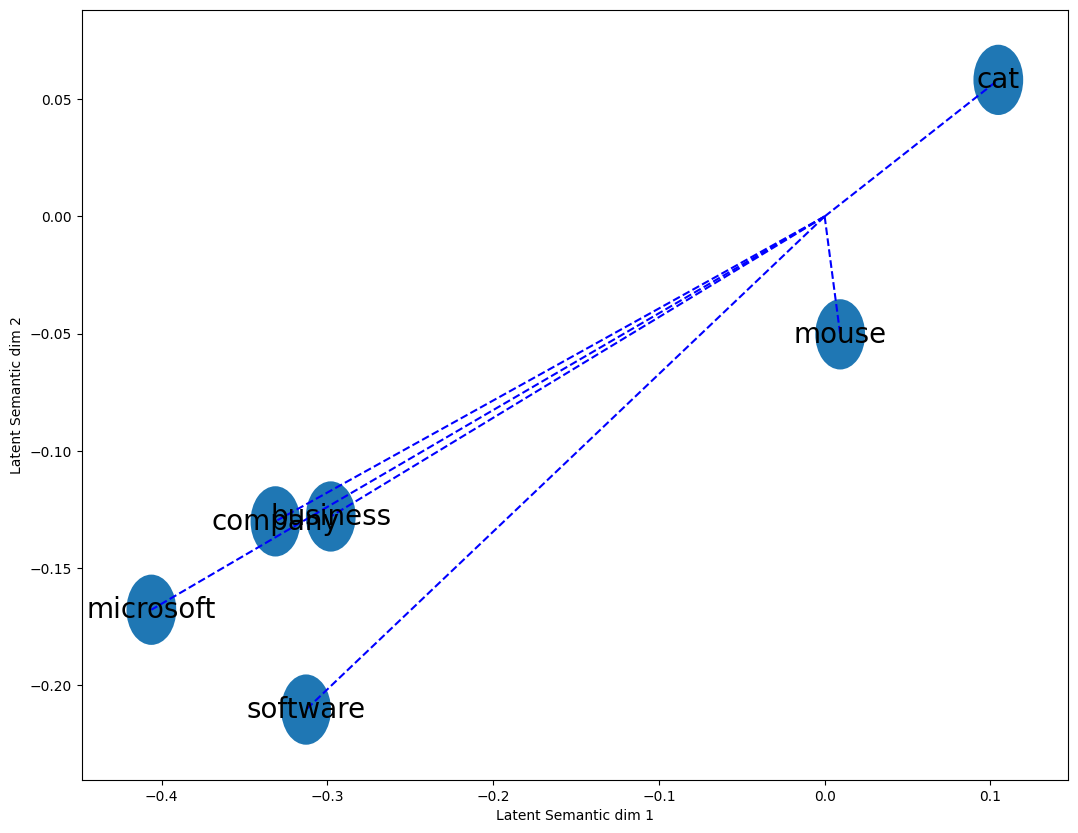

In [57]:
words = ['company', 'business', 'cat', 'software', 'microsoft', 'mouse']
transformed_word_vectors = [get_vector_transform(i, fasttext_word_model, n=2) for i in words]
reg_vecs = np.array([fasttext_word_model.get_word_vector(word) for word in words])

plt.figure(figsize=(28, 10))
ax = plt.subplot(1, 2, 1)
for idx, doc in enumerate(transformed_word_vectors):
    plt.plot([0, doc[0]], [0, doc[1]], 'b--')
    circle = plt.Circle((doc[0], doc[1]), radius=0.015)
    ax.add_patch(circle)
    label = ax.annotate(words[idx], xy=(doc[0], doc[1]), fontsize=20, ha="center", va="center")

plt.xlabel('Latent Semantic dim 1')
plt.ylabel('Latent Semantic dim 2')

In [58]:
n = 2 # Number of principal components to do with
to_compare = ['software', 'business', 'world'] # Three words, that should be labeled as three different things
for word in words:
    for comparison in to_compare:
        print(f"{word}-{comparison}: {cos_sim(get_vector_transform(word, fasttext_word_model, n), get_vector_transform(comparison, fasttext_word_model,n))}")


company-software: 0.89732825756073
company-business: 0.9700983166694641
company-world: -0.5399829745292664
business-software: 0.8014085292816162
business-business: 1.0
business-world: -0.6927511096000671
cat-software: 0.5380064249038696
cat-business: -0.050332002341747284
cat-world: 0.539342999458313
software-software: 0.9999999403953552
software-business: 0.8014085292816162
software-world: -0.3075994551181793
microsoft-software: 0.9615396857261658
microsoft-business: 0.9093630313873291
microsoft-world: -0.41476109623908997
mouse-software: 0.8366438150405884
mouse-business: 0.3568354845046997
mouse-world: 0.09790429472923279


## Another strength of fasttext: Spelling errors

A good thing if we want to use fasttext on a character level, is that it will be able to understand spelling errors. We're going to test this now by replacing a bunch of letters in our test set randomly with other words and once more test the accuracy of the word-wise fasttext vs the character-wise fasttext

In [59]:
def dyslexibot(test_set: list, p=0.05, extra_scuffed=False):
    """
    tHe AlMiGhTy dyslexibot(tm) replaces letters with probability p
    extra_scuffed does what it says: it makes the replacements even harder to guess
    This function is pretty ineffective, if you want to spruce it up, you are welcome to do so
    """

    if extra_scuffed:
        test_set_letters = np.array(list(set(''.join(test_texts)))) # Can replace with all letters currently in test set
    else:
        test_set_letters = np.array(list(string.ascii_lowercase)) # Can only replace with lowercase letters

    new_test_set = [text.split(' ') for text in test_set.copy()]

    print("Replacing text")
    for i, text in tqdm(enumerate(new_test_set)):
        for r, word in enumerate(text):
            word = list(word)
            for t, letter in enumerate(word):
                rand = random.uniform(0, 1)

                if extra_scuffed and rand < p: # We replace even spaces!
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

                elif letter != ' ' and rand < p:
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

            text[r] = ''.join(word)
        new_test_set[i] = ' '.join(text)
    return np.array(new_test_set)

In [66]:
# Showing that dyslexibot works
text = ["have you heard of the tragedy of darth plagueis the wise"]
print(dyslexibot(text, p=0.10, extra_scuffed=False))

Replacing text


1it [00:00, 2576.35it/s]

['havp you hperd of tte tragedu oo dazth plagueis the wism']


Now we want to test the fasttext classifier on the text generated by dyslexibot, use your previously made testing function, to test the accuracy of both word-gram and character-gram model for various values of p in dyslexibot. For extra spice, try toggling the extra_scuffed mode.

In [68]:
dyslexitext = dyslexibot(test_texts, p=0.20, extra_scuffed=False)

# Insert your training loop here to calculate the test accuracy on the dyslexitext
# using both the word-wise fasttext and the character-wise fasttext

# TODO: What it says one line above

test_accuracy(fasttext_word_model, dyslexitext)
test_accuracy(fasttext_char_model, dyslexitext)

Replacing text


7600it [00:02, 3162.56it/s]


73.72 % correct
84.12 % correct


**Question: You should have seen a noticable difference in the accuracy of character vs word models for everything up until now. Explain why this inaccuracy between models difference occur**

There is a big difference in accuracy in checking spelling errors. Character level seems to be way better, which is pretty obvious since it is able to see each character and make a word, even if one or two characters have been changed. The word level model is not as good as classifying the word, if is has been changed, as it works on a word level.

**Question: Tweak the p-value of dyslexibot, how does a higher or lower p impact the performance of the character model fasttext and the word fasttext? Why are they impacted like this?**

See below for testing

Higher p-value = lower accuracy. This is because there is a higher chance that the new word differs more from its original form and is therefore much more difficult to guess for the models.

**Make a plot, including the test accuracy of both fasttext_word_model and fasttext_char_model vs the p-value of dyslexibot, comment on the plot (It is reccomended not to choose too many values of p, as it can take a long time to run)**

See the plot below.

As written is question 1 in this block, the character wise approach seems much better due to the same reasons as mentioned before.


In [69]:
dyslexitext = dyslexibot(test_texts, p=0.40, extra_scuffed=False)
test_accuracy(fasttext_word_model, dyslexitext)
test_accuracy(fasttext_char_model, dyslexitext)

Replacing text


7600it [00:08, 930.37it/s] 


44.83 % correct
67.59 % correct


In [70]:
dyslexitext = dyslexibot(test_texts, p=0.60, extra_scuffed=False)
test_accuracy(fasttext_word_model, dyslexitext)
test_accuracy(fasttext_char_model, dyslexitext)

Replacing text


7600it [00:11, 643.43it/s] 


29.0 % correct
44.67 % correct


In [71]:
dyslexitext = dyslexibot(test_texts, p=0.40, extra_scuffed=True)
test_accuracy(fasttext_word_model, dyslexitext)
test_accuracy(fasttext_char_model, dyslexitext)

Replacing text


7600it [00:04, 1752.99it/s]


45.33 % correct
69.83 % correct


In [93]:
x = [5, 10, 15, 20, 30, 40, 50, 75, 100]
y_word = []
y_char = []
for p in x:
    p = p/100
    dyslexitext = dyslexibot(test_texts, p=p, extra_scuffed=False)
    y_word.append(test_accuracy(fasttext_word_model, dyslexitext))
    y_char.append(test_accuracy(fasttext_char_model, dyslexitext))

Replacing text


7600it [00:01, 6972.73it/s]


88.34 % correct
89.38 % correct
Replacing text


7600it [00:01, 5300.54it/s]


84.68 % correct
87.92 % correct
Replacing text


7600it [00:01, 3931.63it/s]


80.38 % correct
86.49 % correct
Replacing text


7600it [00:03, 2255.95it/s]


73.17 % correct
84.12 % correct
Replacing text


7600it [00:03, 1986.51it/s]


58.51 % correct
77.41 % correct
Replacing text


7600it [00:05, 1457.70it/s]


44.95 % correct
67.14 % correct
Replacing text


7600it [00:05, 1393.53it/s]


35.61 % correct
55.12 % correct
Replacing text


7600it [00:09, 794.97it/s]


26.16 % correct
32.28 % correct
Replacing text


7600it [00:11, 673.77it/s]


24.41 % correct
24.78 % correct


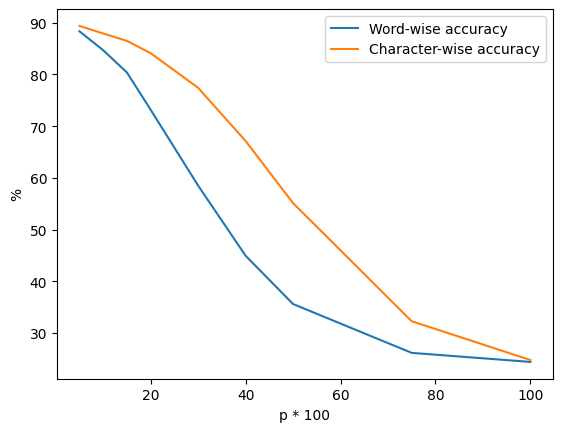

In [106]:
import matplotlib.pyplot as plt
import importlib

importlib.reload(plt)

plt.plot(x, y_word, label="Word-wise accuracy")
plt.plot(x, y_char, label="Character-wise accuracy")
plt.ylabel("%")
plt.xlabel("p * 100")
plt.legend()
plt.show()


# Custom text classification

Finally, to show the robustness of fasttext (and for fun), you are to make your own text and try to let fasttext classify this as one of the four models. Rememeber that the original dataset used texts of around 240 words, so you can either experiment with texts shorter or longer than this and see whether the accuracy is significantly different.

As an extra challenge, you can try to create a text which is as close to the model's decision boundary as possible, IE. one that is as close as possible to being classified as either two or more of the classes

In [101]:
own_text = """
Elon Musk is a South African-born entrepreneur, inventor, and businessman known for his innovative technologies and ambitious business ventures. He has co-founded several successful companies, including PayPal, SpaceX, Tesla, Neuralink, and The Boring Company.

One of Musk's most significant contributions to technology is SpaceX, a company he founded in 2002 with the goal of making space travel affordable and accessible. SpaceX has made remarkable achievements, including being the first privately-funded company to send a spacecraft to the International Space Station and successfully landing and reusing rockets. This has revolutionized the space industry and made space exploration more cost-effective.

Musk is also the CEO of Tesla, an electric car company that is revolutionizing the automotive industry. Tesla's mission is to accelerate the transition to sustainable energy, and Musk has been a vocal advocate for reducing our reliance on fossil fuels. Tesla's innovative technologies, such as electric powertrains and autopilot systems, have made electric cars more accessible and popular than ever before.

In addition to his technological ventures, Musk is also involved in the development of AI and neural technology through his company Neuralink. This company aims to create brain-machine interfaces that will revolutionize the way humans interact with technology.

Musk's business ventures have not been without controversy, including disputes with the SEC over his use of Twitter and concerns over working conditions at Tesla. However, his innovative technologies and ambitious goals have inspired many and have helped to shape the future of technology and business.
"""

own_text = own_text.replace("\n", " ")
print(len(own_text.split()), "words")

print("The text is classified as: ", fasttext_word_model.predict(own_text))#[0][0][9:])

244 words
The text is classified as:  (('__label__Sci/Tec',), array([0.88130432]))


**Question: What was your text classified as and why do you think the model choose that with the given accuracy?**

Well, we found a text of Elon Musk that has many words associated with Science and Tech, so that is probably the reason it was correct. A classification of business could maybe also be approved here. Many texts could potentially have multiple classes.

## Extremely optional task

It's quite a waste to have all those juicy principle components of the embedding matrices without using them in a classifier of some sort, right?

Create a classifier to classify texts as one of the four labels, based on the projections of their words unto a number of the principle components of the embedding matrices. Compare this classifier to the fasttext classifier and reflect on their performance.


In [ ]:
raise NotImplementedError("Asking for a whole classifier is a bit much, no?")